In [5]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement qiskit=="0.46" (from versions: 0.3.2, 0.3.3, 0.3.4, 0.3.5, 0.3.6, 0.3.7, 0.3.8, 0.3.9, 0.3.10, 0.3.11, 0.3.12, 0.3.13, 0.3.14, 0.3.15, 0.3.16, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.4.14, 0.4.15, 0.5.0, 0.5.1, 0.5.2, 0.5.3, 0.5.4, 0.5.5, 0.5.6, 0.5.7, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.1, 0.9.0, 0.10.0, 0.10.1, 0.10.2, 0.10.3, 0.10.4, 0.10.5, 0.11.0, 0.11.1, 0.11.2, 0.12.0, 0.12.1, 0.12.2, 0.13.0, 0.14.0, 0.14.1, 0.15.0, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.18.0, 0.18.1, 0.18.2, 0.18.3, 0.19.0, 0.19.1, 0.19.2, 0.19.3, 0.19.4, 0.19.5, 0.19.6, 0.20.0, 0.20.1, 0.21.0, 0.22.0, 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.23.5, 0.23.6, 0.24.0, 0.24.1, 0.25.0, 0.25.1, 0.25.2, 0.25.3, 0.25.4, 0.26.0, 0.26.1, 0.26.2, 0.27.0, 0.28.0, 0.29.0, 0.29.1, 0.30.0, 0.30.1, 0.31.0, 0.32.0, 0.32.1, 0.33.0, 0.33.1, 0.34.0, 0.34.1, 0.34.2, 0.35.0, 0.36.0, 0.36.1, 0.36.

In [1]:
import math
from math import pi

import numpy as np

import cv2

from utils import image_generate, plot_to_compare, calculate_mse, plot_mse

import qiskit
from qiskit.extensions import XGate
from qiskit import transpile, assemble
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.visualization import circuit_drawer
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit.circuit.library.standard_gates.ry import RYGate
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.circuit.library import QFT

from skimage.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from ionq_config import coupling_map, basis_gates

from ibm_washington_config import coupling_map, basis_gates

C:\Users\jfcoa\AppData\Local\Temp\ipykernel_15336\3687143286.py:11: DeprecationWarning: The qiskit.extensions module is deprecated since Qiskit 0.46.0. It will be removed in the Qiskit 1.0 release.
  from qiskit.extensions import XGate


In [2]:
def quantum_adder(circuit, epsilon):
    qubits = circuit.qubits
    n_qubits = circuit.num_qubits
    
    qft = QFT(n_qubits, do_swaps=False).to_instruction()
    circuit.append(qft, qubits)
    
    for i in range(n_qubits):
        circuit.p(2 * pi * epsilon / 2**(i + 1), qubits[n_qubits - i - 1])
    
    iqft = QFT(n_qubits, do_swaps=False, inverse=True).to_instruction()
    circuit.append(iqft, qubits)


def quantum_edge_detection(circuit):
    qubits = circuit.qubits
    ancilla = qubits[0]
    
    circuit.h(ancilla)
    quantum_adder(circuit, -1)
    circuit.h(ancilla)
    circuit.x(ancilla)

In [3]:
def backend_sim(qc, backend, shots):
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=shots)
    job = backend.run(qobj)
    result = job.result()
    counts = result.get_counts()
    return result, counts

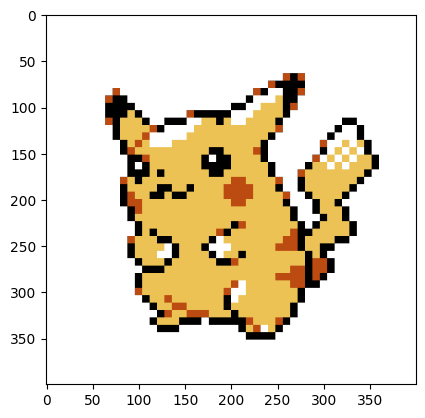

In [4]:
image = plt.imread('images/pikachu.png')
plt.imshow(image)
plt.show()

In [5]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = np.asarray(image)
image = np.interp(image, (0, 1), (0, 255))

In [6]:
print(image)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


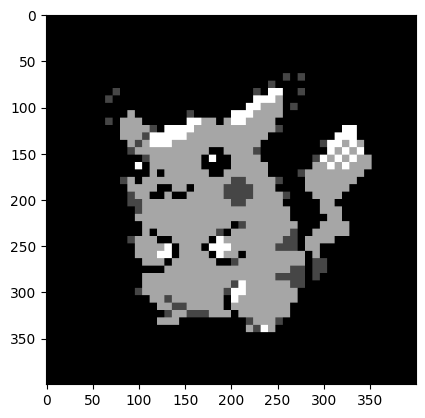

In [7]:
plt.imshow(image, cmap='gray')

In [8]:
# Image flattening into 1D vector for convenience and simplicity.
input_im = image.copy().flatten()

# Transform the normalized values into angles
thetas = np.interp(input_im, (0, 255), (0, np.pi/2))

# Number of required qubits needed 
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [9]:
# Sets the qubits needed for the circuit
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg') # target qubit

# Sets the bits that will hold the measurements result
cr = ClassicalRegister(O.size+c.size, "cl_reg")

# Creates the quantum circuit
qc = QuantumCircuit(c, O, cr)
num_qubits = qc.num_qubits

# Applies quantum gates to each initial qubit in the circuit
qc.h(O) # h -> Hadamard gate

controls = []
for i, _ in enumerate(O):
    controls.extend([O[i]]) # Store the no-target qubits (also named controls)
for i, theta in enumerate(thetas):
    # Generate the different possible states of our qubits
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(O[k]) # Apply X-gate to qubits in state '1'
    qc.barrier()
    
    # Applies the Ry multi-controlled gate to all the circuit qubits
    qc.mcry(theta=2*theta,
                  q_controls=controls,
                  q_target=c[0])
    
    qc.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(O[k]) # Again, we apply X-gate to qubits in state '1'
    qc.barrier()

In [10]:
quantum_edge_detection(qc)
qc.measure(list(reversed(range(qc.num_qubits))), list(range(cr.size)))
print(qc.depth())
shots = 8192
backend = Aer.get_backend('qasm_simulator')
result, counts = backend_sim(qc, backend, shots)

1600006


C:\Users\jfcoa\AppData\Local\Temp\ipykernel_15336\3912465395.py:5: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend = Aer.get_backend('qasm_simulator')


KeyboardInterrupt: 

In [11]:
print(counts)

NameError: name 'counts' is not defined